# Making the most of environmental data for health data researchers

The Jupyter notebook provides reproducibility for the Evaluation section figures of the paper.

## Figure 2: Time spent to complete each task during the usability experiment


In [67]:
# Import necessary libraries and specify figures parameters
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
from functools import reduce
import scipy.stats
import matplotlib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
# matplotlib parameters to export figures to latex with the adequate font type
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib parameters for figures layout
plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.dpi'] = 100

In [68]:
# 1. Import CSV files from the 'TaskTime2' directory
TimeTask_folder = 'TaskTime2'
extension = 'csv'

# List of all the files available
csvFilesAvail = glob.glob(TimeTask_folder + '/*.{}'.format(extension))
# Function to read and format TaskTime files for analysis
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(csvFilesAvail)

['TaskTime2/TimeTaskP10.csv', 'TaskTime2/TimeTaskP4.csv', 'TaskTime2/TimeTaskP3.csv', 'TaskTime2/TimeTaskP5.csv', 'TaskTime2/TimeTaskP7.csv', 'TaskTime2/TimeTaskP8.csv', 'TaskTime2/TimeTaskP6.csv', 'TaskTime2/TimeTaskP9.csv', 'TaskTime2/TimeTaskP1.csv', 'TaskTime2/TimeTaskP2.csv']


In [69]:
# 2. Define function to format the CSV files for analysis
def taskTimeFormat(csvFilePath):
    TT_df = pd.read_csv(csvFilePath)
    # Convert to datetime format and extract minutes
    TT_df['SingleTime'] = TT_df.SingleTime.apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f')) - datetime.strptime(
        '00:00:00.0', '%H:%M:%S.%f')
    TT_df['SingleTime'] = TT_df['SingleTime'].apply(lambda x: x / np.timedelta64(1, 'm'))
    # Set index for the different task for a future merge
    TT_df = TT_df.set_index('Task')
    # Drop unnecessary columns for this analysis
    TT_df = TT_df[['SingleTime']]
    # Rename columns to add participants number
    TT_df.rename(
        columns={'SingleTime': csvFilePath.partition('''TaskTime2/TimeTask''')[2].partition('.csv')[0]},
                 inplace=True)
    return TT_df

# 3. Apply function to all the data sets and merge them into a single one
TT_df_list = [taskTimeFormat(item) for item in csvFilesAvail]
TT_Summary = reduce(lambda left, right: pd.merge(left, right, on='Task'), TT_df_list)
TT_Summary

,P10,P4,P3,P5,P7,P8,P6,P9,P1,P2
Task,,,,,,,,,,
T1,7.859833,4.159167,5.284167,4.899333,7.719833,12.416000,6.808167,6.340833,3.018833,5.802167
T2,4.757333,2.062333,6.316333,4.356500,6.822833,10.203500,7.772333,5.312833,5.851167,3.344333
T3,6.186667,3.919500,6.718000,6.166000,10.084167,11.778500,5.878833,7.853167,5.255167,7.880667
T4,6.001500,3.485333,8.462333,3.152500,9.372833,10.073833,5.553333,5.358000,9.157167,6.377000
T5,13.966333,7.105000,9.045000,7.420833,12.888833,13.781833,11.663167,9.446500,15.453167,13.326000
T6,1.430500,2.218167,1.567667,1.435000,1.001333,3.298000,2.881667,2.843667,1.739000,2.991833
T7,2.162833,0.665000,1.999000,4.359667,1.726000,11.385667,1.271667,1.391000,6.994333,3.825333


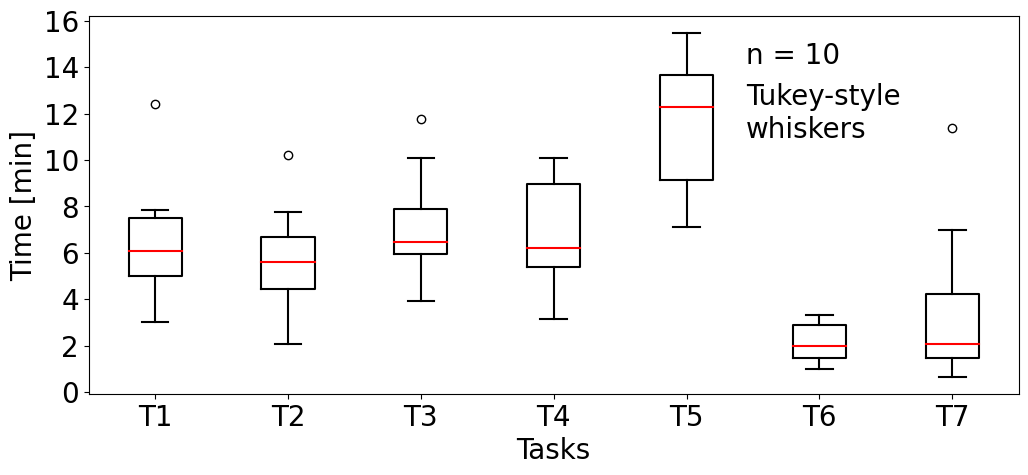

In [70]:
# 4. Plot Figure 2
labelsT = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
bpTime = TT_Summary.T.plot(kind='box', fontsize=20, widths=0.4, labels=labelsT,
                           # patch_artist=True, notch=True, bootstrap=10000,
                           color=dict(boxes='black', whiskers='black', medians='red', caps='black'),
                           boxprops=dict(linestyle='-', linewidth=1.5),
                           medianprops=dict(linestyle='-', linewidth=1.5, color='red'),
                           whiskerprops=dict(linestyle='-', linewidth=1.5),
                           capprops=dict(linestyle='-', linewidth=1.5),
                           )
plt.ylabel('Time [min]', fontsize=20)
plt.xlabel('Tasks', fontsize=20)
leg = plt.legend(['n = 10', 'Tukey-style\nwhiskers'],
                 loc='upper right', ncol=1,
                 bbox_to_anchor=(0.9, 1),
                 frameon=False, handlelength=0.0,
                 fontsize=20)


for legobj in leg.legendHandles:
    legobj.set_linewidth(0.0)


In [71]:
# 5. Display IQR and Median to sort the tasks by complexity
# Define function to calculate interquartile range
def find_iqr(x):
  return np.subtract(*np.percentile(x, [75, 25])).round(2)

# calculate IQR and median for all columns
IQR_df = TT_Summary.T.apply(find_iqr).reset_index(name='IQR')
Med_df = TT_Summary.T.apply(lambda x: x.quantile(0.5).round(2)).reset_index(name='Median')

# Merge and apply categories based in IQR and Median
statsSummary = pd.merge(IQR_df, Med_df, how='inner')
statsSummary['Complexity'] = np.where( 
    (statsSummary['IQR'] < 3) & (statsSummary['Median'] < 3), 'low',
        np.where((statsSummary['IQR'] < 3) & (statsSummary['Median'] < 7), 'moderate',
                 np.where((statsSummary['IQR'] > 3) & (statsSummary['Median'] < 7),'high','very_high')))

statsSummary

,Task,IQR,Median,Complexity
0,T1,2.50,6.07,moderate
1,T2,2.24,5.58,moderate
2,T3,1.92,6.45,moderate
3,T4,3.58,6.19,high
4,T5,4.52,12.28,very_high
5,T6,1.40,1.98,low
6,T7,2.75,2.08,low


## Figure 3: PSSUQ scores box plot with the four averaged metrics (SysUse, InfoQual, IntQual and Overall) on the right end with a sample sizes of 80, 70, 30 and 190.

In [62]:
# 1. Import PSSUQ
PSSUQ_filePath = 'PSSUQ_ANG_SERDIF_AVERT_01.csv'
PSSUQ_df = pd.read_csv(PSSUQ_filePath)
nParticipants = len(PSSUQ_df.columns) - 1

# 2. Prepare datasets to combine in boxplots
PSSUQ_df = PSSUQ_df.set_index('Questions')

# 2.1. Individual questions
PSSUQ_IQ = PSSUQ_df.T

# 2.2. Grouped questions 3 groups (1-18)
PSSUQ_GQ = PSSUQ_df
PSSUQ_GQ['ScoresG'] = ['SysUse', 'SysUse', 'SysUse', 'SysUse', 'SysUse', 'SysUse', 'SysUse', 'SysUse',
                       'InfoQual', 'InfoQual', 'InfoQual', 'InfoQual', 'InfoQual', 'InfoQual', 'InfoQual',
                       'IntQual', 'IntQual', 'IntQual', 'Overall']
# Remove question 19
PSSUQ_GQ = PSSUQ_GQ[PSSUQ_GQ.ScoresG != 'Overall']
PSSUQ_GQ = PSSUQ_GQ.groupby(['ScoresG'], sort=False).mean().T

# 2.3. Overall (1-19)
PSSUQ_OQ = pd.DataFrame({'Overall': PSSUQ_df.mean(axis=0)})

# 2.4. Join into one dataset
PSSUQ_Summary = PSSUQ_IQ.join(PSSUQ_GQ).join(PSSUQ_OQ)
PSSUQ_Summary

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,SysUse,InfoQual,IntQual,Overall
P1,2.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,5.0,2.0,2.0,2.0,3.0,2.0,3.0,2.0,2.0,4.0,3.0,1.875,2.714286,2.666667,2.368421
P2,4.0,4.0,3.0,6.0,5.0,4.0,3.0,3.0,6.0,3.0,5.0,3.0,3.0,2.0,3.0,3.0,3.0,5.0,6.0,4.000,3.571429,3.666667,3.894737
P3,3.0,3.0,1.0,2.0,2.0,3.0,2.0,1.0,6.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,5.0,4.0,2.125,2.142857,3.000000,2.368421
P4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000000,1.000000,1.000000
P5,1.0,2.0,3.0,3.0,3.0,3.0,2.0,4.0,6.0,2.0,3.0,2.0,2.0,2.0,2.0,1.0,2.0,3.0,2.0,2.625,2.714286,2.000000,2.526316
P6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000,1.166667,1.333333,1.111111
P7,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,NaN,2.0,3.0,2.0,2.0,1.0,3.0,3.0,2.0,2.0,2.0,1.875,2.166667,2.333333,2.055556
P8,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,4.0,3.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.375,2.000000,1.666667,1.631579
P9,1.0,1.0,2.0,2.0,3.0,1.0,2.0,2.0,5.0,2.0,1.0,3.0,2.0,2.0,2.0,1.0,1.0,NaN,1.0,1.750,2.428571,1.000000,1.888889
P10,3.0,2.0,2.0,3.0,4.0,3.0,3.0,2.0,5.0,2.0,3.0,4.0,2.0,3.0,1.0,2.0,3.0,6.0,3.0,2.750,2.857143,3.666667,2.947368


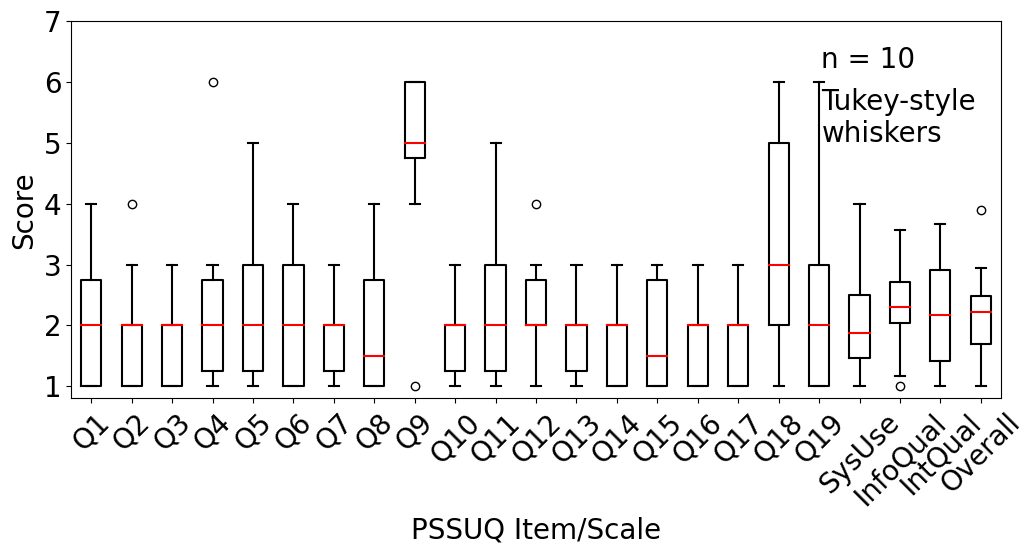

In [72]:
# 3. Plot PSSUQ box plots
bp = PSSUQ_Summary.plot(kind='box',
                    color=dict(boxes='black', whiskers='black', medians='red', caps='black'),
                    boxprops=dict(linestyle='-', linewidth=1.5, color='black'),
                    # flierprops=dict(linestyle='-', linewidth=1.5),
                    medianprops=dict(linestyle='-', linewidth=1.5, color='red'),
                    whiskerprops=dict(linestyle='-', linewidth=1.5, color='black'),
                    capprops=dict(linestyle='-', linewidth=1.5, color='black'),
                    showfliers=True, grid=False, rot=45,  fontsize=20,
                    # range
                    # patch_artist=True,
                    )

plt.ylabel('Score', fontsize=20)
plt.xlabel('PSSUQ Item/Scale', fontsize=20)
plt.ylim([0.8,7])
# number of participants for the legend
nPartPlot = 'n = ' + str(nParticipants)
leg = bp.legend([nPartPlot, 'Tukey-style\nwhiskers'],
                loc='upper right', ncol=1,
                frameon=False, handlelength=0.0,
                fontsize=20)
for legobj in leg.legendHandles:
    legobj.set_linewidth(0.0)